In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit

In [2]:
#e_225 = np.load('europa_225_2.2microns', allow_pickle=True)
e_225 = np.load('europa_225.npy', allow_pickle=True)
wave = np.loadtxt('wave.txt')

europa_spec = e_225[:,64,64]*25

In [3]:
#Load spectral data
mg_chloride = np.loadtxt('MgCl2.2H2O_80K.txt', skiprows=4)
mg_chlorate = np.loadtxt('Mg(ClO3)2.6H2O_80K.txt', skiprows=4)
mg_perchlorate = np.loadtxt('Mg(ClO4)2.6H2O_80K.txt', skiprows=4)
sulfuric_acid = np.loadtxt('H2SO4.8H2O.csv', delimiter=',')

#Wavelength, n, k, %T
amor_nk = np.loadtxt('amorph_high.txt')
crys_nk = np.loadtxt('crys_120K.txt')

# Build Spectral Library

In [4]:
from dataclasses import dataclass

@dataclass
class spectrum:
    """Class for keeping track of a."""
    name: str
    wave: np.array #wavelengths (microns)
    A: np.array #spectral albedo
        
def shkuratov(wave, n, k, S, q=0.7): 
    """This function computes a spectra with the shkuratov radiative 
    transfer equations for the specified inputs. 
    It returns the spectral albedo (reflectance spectra) at the wavelengths 
    input in wave. 
     
    INPUTS: 
        wave: array: array of wavelengths for corresponding n and k values 
        n, k: arrays: arrays of n and k values to be use din shkuratov formula 
        S: number: grain size, in microns 
        q: default 0.7: volume filling fraction (default is 79%) 
         
    OUTPUT: 
        A: array: spectral albedo values for wavelength in wave
    """
    
    #Fresnell coefficient 
    r_o = ((n-1)**2)/((n+1)**2)  
 
    #Reflection Coefficients 
    R_i = 1.04 - (1/(n**2)) 
    R_e = r_o + 0.05 
    R_b = (0.28*n - 0.20)*R_e 
    R_f = R_e-R_b 
    
    #Transmission Coefficients 
    T_e = 1 - R_e 
    T_i = 1 - R_i 
 
    #Tau: optical density 
    tau = (4*np.pi*k*S)/wave 
 
    #Light Scattering Indicatrices
    r_b = R_b + 0.5*T_e*T_i*R_i*np.exp(-2*tau )/(1 - R_i*np.exp(-1*tau)) 
    r_f = R_f + T_e*T_i*np.exp(-1*tau) + 0.5*T_e*T_i*R_i*np.exp(-2*tau )/(1 - R_i*np.exp(-1*tau))
    
    #1D indicatrices 
    rho_b = q*r_b 
    rho_f = q*r_f + (1-q)
    
    #Spectral Albedo 
    return ((1 + rho_b**2 - rho_f**2)/(2*rho_b)) - np.sqrt(((1 + rho_b**2 - rho_f**2)/(2*rho_b))**2 -1)
    

In [5]:
spec_library = []

#For now, populate spec_library with spectra to be used in linear model
# Mg salts (hydrated)
spec_library.append(spectrum(name='Mg chloride', wave = mg_chloride[:,0], A = mg_chloride[:,1]))
spec_library.append(spectrum(name='Mg chlorate', wave = mg_chlorate[:,0], A = mg_chlorate[:,1]))
spec_library.append(spectrum(name='Mg perchlorate', wave = mg_perchlorate[:,0], A = mg_perchlorate[:,1]))

#Amorphous Water
spec_library.append(spectrum(name='Amorphous 5 micron', wave=amor_nk[:,0],
                   A = shkuratov(amor_nk[:,0], amor_nk[:,1], amor_nk[:,2], 5., q=0.7)))
spec_library.append(spectrum(name='Amorphous 25 micron', wave=amor_nk[:,0],
                   A = shkuratov(amor_nk[:,0], amor_nk[:,1], amor_nk[:,2], 25., q=0.7)))
spec_library.append(spectrum(name='Amorphous 200 micron', wave=amor_nk[:,0],
                   A = shkuratov(amor_nk[:,0], amor_nk[:,1], amor_nk[:,2], 200., q=0.7)))
spec_library.append(spectrum(name='Amorphous 1 mm', wave=amor_nk[:,0],
                   A = shkuratov(amor_nk[:,0], amor_nk[:,1], amor_nk[:,2], 1000., q=0.7)))

#Crystalline Water
spec_library.append(spectrum(name='Crystalline 25 micron', wave=crys_nk[:,0],
                   A = shkuratov(crys_nk[:,0], crys_nk[:,1], crys_nk[:,2], 25., q=0.7)))
spec_library.append(spectrum(name='Crystalline 200 micron', wave=crys_nk[:,0],
                   A = shkuratov(crys_nk[:,0], crys_nk[:,1], crys_nk[:,2], 200., q=0.7)))
spec_library.append(spectrum(name='Crystalline 1 mm', wave=crys_nk[:,0],
                   A = shkuratov(crys_nk[:,0], crys_nk[:,1], crys_nk[:,2], 1000., q=0.7)))

#Sulfuric Acid Octahydrate
spec_library.append(spectrum(name='Sulfuric Acid Octahydrate', wave=sulfuric_acid[:,0], A = sulfuric_acid[:,1]))


In [88]:
from abc import ABC, abstractmethod
from typing import Callable, List, Tuple, Optional, Sequence
from tqdm.auto import tqdm
from copy import deepcopy
from lmfit import Parameters, Minimizer

def fill_parameters(params: Parameters, values: Sequence[float]) -> Parameters:
    assert len(params) == len(values)
    params = deepcopy(params)
    for p,v in zip(params.values(), values):
        p.value = v
    return params

class SpectralModel(ABC):
    """ An abstract class representing a model which can be fit, and which can 
    be used to estimate spectral intensity. 
    """
    
    @property
    @abstractmethod
    def parameters(self) -> Parameters:
        """Get a copy of the model parameters. """
        pass
    
    @abstractmethod
    def set_parameters(self, params: Parameters):
        pass
    
    @abstractmethod
    def estimate(self, params: Parameters) -> np.ndarray:
        pass
    
    def residual_fn(self, b: np.ndarray) -> Callable[[Parameters], np.ndarray]:
        """Get a function which computes residuals when provided parameters. 
        
        Used for lmfit optimization.
        """
        def _fn(params):
            return self.estimate(params) - b
        return _fn
    
    def fit(self, b: np.ndarray, parameters=None, *args, **kwargs) -> Tuple[lmfit.minimizer.MinimizerResult, np.ndarray]:
        """ Compute a fit, given target values 'b'. Uses the (optional) parameters to start the minimization. 
        
        Returns a MinimizerResult as well as an array of residual sum-of-square errors, indexed by iteration."""
        errors = []
        pbar = tqdm()
        def log_errors(params, iter, res):
            err = np.linalg.norm(res)**2
            pbar.set_description(f'err = {err:.3f}')
            errors.append(err)
            pbar.update(1)
            
        if parameters is None:
            parameters = self.parameters
        
        mini = Minimizer(self.residual_fn(b), parameters, iter_cb=log_errors)
        out = mini.minimize(*args, **kwargs)
        self.set_parameters(out.params)
        return out, np.array(errors)
    
    def fill_parameters(self, values: Sequence[float]):
        """ Set the values on the model's parameters. """
        self.set_parameters(
            fill_parameters(self.parameters, values)
        )
    
class NaiveLinearModel(SpectralModel):
    """A simple linear model, based on known wavelength and spectral library. """
    def __init__(self, waves: np.ndarray, spec_library: List[spectrum]):
        # initialize model matrix
        self.A = np.zeros((len(waves), len(spec_library)))
        for i,spec in enumerate(spec_library):
            self.A[:,i] = np.interp(waves, spec.wave, spec.A)
            
        # initialize parameters
        self._params = Parameters()
        for i,spec in enumerate(spec_library):
            self._params.add(spec.name.replace(" ", "_"), vary=True, min=0)
            
    def estimate(self, params: Parameters) -> np.ndarray:
        params_dict = params.valuesdict()
        x = np.array([params_dict[key] for key in params_dict.keys()]).flatten()
        return self.A @ x
    
    @property
    def parameters(self):
        return self._params
    
    def set_parameters(self, params):
        self._params = params   

In [84]:
# Remove Nan values from VLT spectrum
waves = wave[np.where(~np.isnan(europa_spec))]
b = europa_spec[np.where(~np.isnan(europa_spec))]

# Naive Linear Model: Ax = b

In [89]:
naive_linear = NaiveLinearModel(waves, spec_library)
naive_linear.fill_parameters(np.random.rand(11)) #Provide random starting conditions to avoid boundary issues
nl_out, nl_errors = naive_linear.fit(b, method='leastsq')

In [90]:
from lmfit import report_fit
report_fit(nl_out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 226
    # data points      = 1989
    # variables        = 11
    chi-square         = 1.46671001
    reduced chi-square = 7.4151e-04
    Akaike info crit   = -14323.3949
    Bayesian info crit = -14261.8457
##  Warning: uncertainties could not be estimated:
    Mg_chloride:                at boundary
    Amorphous_5_micron:         at boundary
    Amorphous_25_micron:        at boundary
    Crystalline_25_micron:      at boundary
    Crystalline_200_micron:     at boundary
[[Variables]]
    Mg_chloride:                1.6732e-09 (init = 0.661865)
    Mg_chlorate:                0.33416057 (init = 0.6905577)
    Mg_perchlorate:             0.00361026 (init = 0.8595501)
    Amorphous_5_micron:         5.9518e-10 (init = 0.5920516)
    Amorphous_25_micron:        1.2812e-09 (init = 0.5769242)
    Amorphous_200_micron:       3.8644e-07 (init = 0.9162124)
    Amorphous_1_mm:             0.15409226 (init = 0.600424

Text(0, 0.5, 'Reflectance')

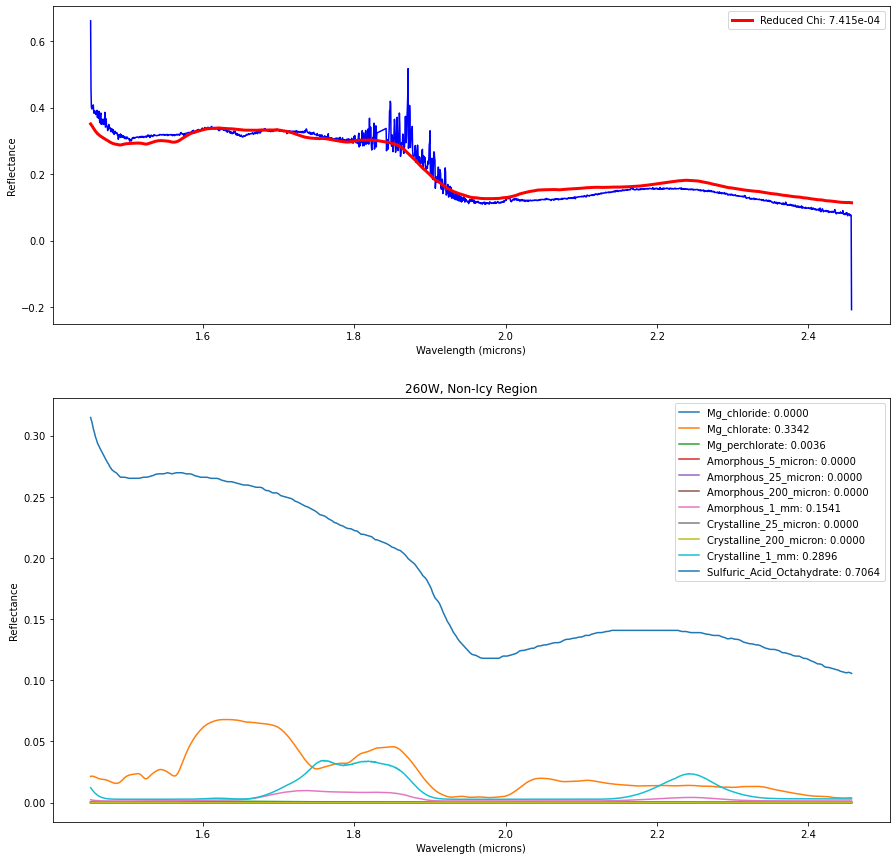

In [171]:
fig, ax = plt.subplots(2,1, figsize=(15,15), 
                       gridspec_kw={'height_ratios': [1.5, 2]})
plt.title('260W, Non-Icy Region')

ax[0].plot(waves, b, color='b')
ax[0].plot(waves, naive_linear.estimate(nl_out.params), color='r', linewidth=3, 
           label='Reduced Chi: '+format(nl_out.redchi,'.3e'))

ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('Reflectance')
ax[0].legend()

#Plot components
for i,p in enumerate(nl_out.params.values()):
    ax[1].plot(waves, naive_linear.A[:,i]*p.value, 
               label=p.name+': '+format(p.value,'0.4f'))
    
ax[1].legend()
ax[1].set_xlabel('Wavelength (microns)')
ax[1].set_ylabel('Reflectance')

# Constrained Linear Model: Ax = b where $\sum x_i = 1$

In [129]:
class ConstrainedLinearModel(SpectralModel):
    """A simple linear model, based on known wavelength and spectral library where the
    sum of coefficients are constrained to be 1. """
    
    def __init__(self, waves: np.ndarray, spec_library: List[spectrum]):
        # initialize model matrix
        self.A = np.zeros((len(waves), len(spec_library)))
        for i,spec in enumerate(spec_library):
            self.A[:,i] = np.interp(waves, spec.wave, spec.A)
            
        # initialize parameters
        self._params = Parameters()
        expr = '1'
        for spec in spec_library[:-1]:
            #Create initial blank paramters to allow expression building
            self._params.add(spec.name.replace(" ", "_"), vary=True, min=0)
            
            #Add to constraint expression
            expr+= '-'+str(spec.name.replace(" ", "_")) 
        #Constrain all parameters to sum to 1    
        self._params.add(spec_library[-1].name.replace(" ", "_"), vary=True, min=0, expr=expr)
            
    def estimate(self, params: Parameters) -> np.ndarray:
        params_dict = params.valuesdict()
        x = np.array([params_dict[key] for key in params_dict.keys()]).flatten()
        return self.A @ x
    
    @property
    def parameters(self):
        return self._params
    
    def set_parameters(self, params):
        self._params = params

In [95]:
constrained_linear = ConstrainedLinearModel(waves, spec_library)
rand = np.random.rand(11)
rand /= np.sum(rand)
constrained_linear.fill_parameters(rand) #Provide random starting conditions (that add to 1) to avoid boundary issues
cl_out, cl_errors = constrained_linear.fit(b, method='leastsq')

In [100]:
report_fit(cl_out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1000
    # data points      = 1989
    # variables        = 10
    chi-square         = 1.62647890
    reduced chi-square = 8.2187e-04
    Akaike info crit   = -14119.7409
    Bayesian info crit = -14063.7870
##  Warning: uncertainties could not be estimated:
    Mg_chloride:                at boundary
    Amorphous_5_micron:         at boundary
    Amorphous_25_micron:        at boundary
    Amorphous_1_mm:             at boundary
    Crystalline_25_micron:      at boundary
    Crystalline_200_micron:     at boundary
[[Variables]]
    Mg_chloride:                3.2236e-09 (init = 0.02400842)
    Mg_chlorate:                0.08044719 (init = 0.0706588)
    Mg_perchlorate:             0.04495818 (init = 0.1119633)
    Amorphous_5_micron:         5.2523e-10 (init = 0.02745599)
    Amorphous_25_micron:        2.4326e-09 (init = 0.05561894)
    Amorphous_200_micron:       0.13313594 (init = 0.2004056)
    Amorph

Text(0, 0.5, 'Reflectance')

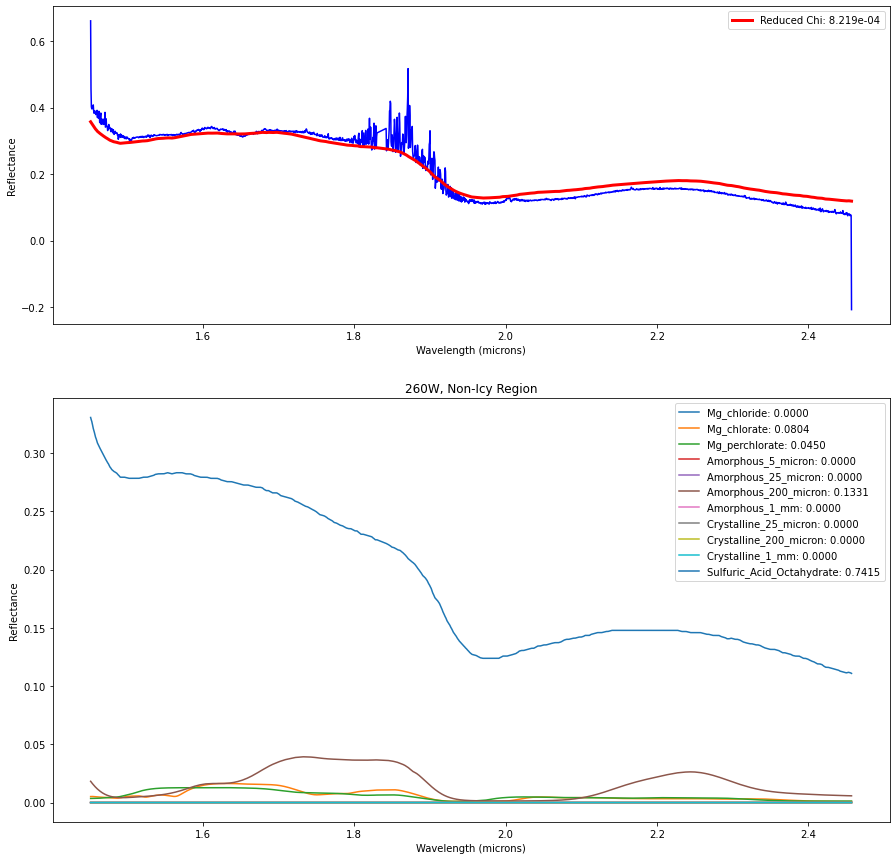

In [170]:
fig, ax = plt.subplots(2,1, figsize=(15,15), 
                       gridspec_kw={'height_ratios': [1.5, 2]})
plt.title('260W, Non-Icy Region')

ax[0].plot(waves, b, color='b')
ax[0].plot(waves, constrained_linear.estimate(cl_out.params), color='r', linewidth=3, 
           label='Reduced Chi: '+format(cl_out.redchi, '.3e'))

ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('Reflectance')
ax[0].legend()

#Plot components
for i,p in enumerate(cl_out.params.values()):
    ax[1].plot(waves, constrained_linear.A[:,i]*p.value, 
               label=p.name+': '+format(p.value,'0.4f'))

#ax[1].set_yscale('log')    
ax[1].legend()
ax[1].set_xlabel('Wavelength (microns)')
ax[1].set_ylabel('Reflectance')

# Linear Model with Slope Variation: $b = \sum x_i A_i *(\lambda + S)$

In [133]:
class SlopeAdjustedModel(SpectralModel):
    """A simple linear model, based on known wavelength and spectral library with an additional fudge
    factor (S) to adjust the spectral slope. 
    
    \sum x_i spec_i * (lambda + S)
    """
    
    def __init__(self, waves: np.ndarray, spec_library: List[spectrum]):
        # initialize model matrix
        self.A = np.zeros((len(waves), len(spec_library)))
        for i,spec in enumerate(spec_library):
            self.A[:,i] = np.interp(waves, spec.wave, spec.A)
            
        # initialize parameters
        self._params = Parameters()
        for spec in spec_library:
            self._params.add(spec.name.replace(" ", "_"), vary=True, min=0)
            
        # Add paramater for S
        self._params.add('S', vary=True, min=0)
            
    def estimate(self, params: Parameters) -> np.ndarray:
        x = np.array([p.value for p in params.values() if p.name != 'S']).flatten()
        S = params['S'].value
        return self.A @ x * (waves+S)
    
    @property
    def parameters(self):
        return self._params
    
    def set_parameters(self, params):
        self._params = params

In [146]:
slope_adjusted = SlopeAdjustedModel(waves, spec_library)
slope_adjusted.fill_parameters(np.concatenate([np.random.rand(11), [1]])) #Provide random starting conditions
sa_out, sa_errors = slope_adjusted.fit(b, method='leastsq')

In [147]:
report_fit(sa_out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17317
    # data points      = 1989
    # variables        = 12
    chi-square         = 1.46746182
    reduced chi-square = 7.4227e-04
    Akaike info crit   = -14320.3757
    Bayesian info crit = -14253.2310
##  Warning: uncertainties could not be estimated:
    Mg_chloride:                at boundary
    Amorphous_5_micron:         at boundary
    Amorphous_25_micron:        at boundary
    Amorphous_200_micron:       at boundary
    Crystalline_25_micron:      at boundary
    Crystalline_200_micron:     at boundary
[[Variables]]
    Mg_chloride:                1.4534e-09 (init = 0.7479711)
    Mg_chlorate:                3.1883e-05 (init = 0.007433733)
    Mg_perchlorate:             3.5749e-07 (init = 0.7366665)
    Amorphous_5_micron:         1.7212e-11 (init = 0.0667338)
    Amorphous_25_micron:        3.0055e-09 (init = 0.3799472)
    Amorphous_200_micron:       1.9796e-09 (init = 0.02736019)
    Amorp

Text(0, 0.5, 'Reflectance')

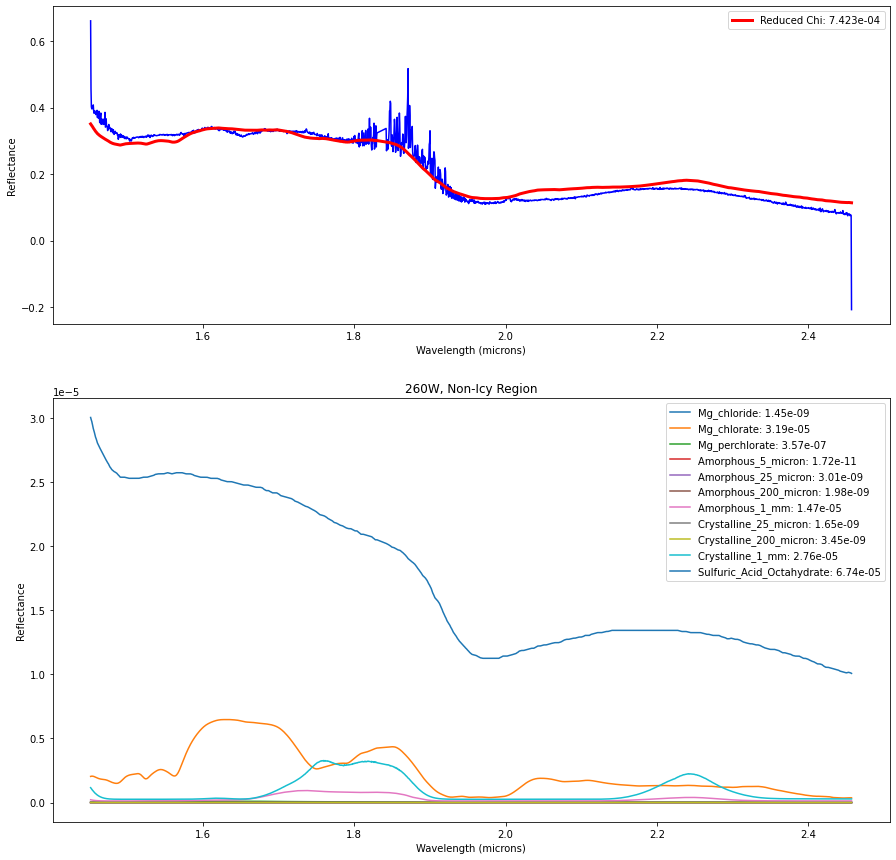

In [169]:
fig, ax = plt.subplots(2,1, figsize=(15,15), 
                       gridspec_kw={'height_ratios': [1.5, 2]})
plt.title('260W, Non-Icy Region')

ax[0].plot(waves, b, color='b')
ax[0].plot(waves, slope_adjusted.estimate(sa_out.params), color='r', linewidth=3, 
           label='Reduced Chi: '+format(sa_out.redchi,'.3e'))

ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('Reflectance')
ax[0].legend()

#Plot components
for i,p in enumerate(sa_out.params.values()):
    if p.name != 'S':
        ax[1].plot(waves, slope_adjusted.A[:,i]*p.value, 
               label=p.name+': '+format(p.value,'.2e'))
    #else:
    #    ax[1].plot(waves, S*waves - 15, label='S: '+format(p.value,'0.4f'))

#ax[1].set_yscale('log')    
ax[1].legend()
ax[1].set_xlabel('Wavelength (microns)')
ax[1].set_ylabel('Reflectance')

# Constrained Linear Model with Slope Variation: $b = \sum x_i A_i *(\lambda + S)$
# where $\sum x_i = 1$

In [154]:
class ConstrainedSlopeAdjustedModel(SpectralModel):
    """A simple linear model, based on known wavelength and spectral library with an additional fudge
    factor (S) to adjust the spectral slope. 
    
    \sum x_i spec_i * (lambda + S)
    """
    
    def __init__(self, waves: np.ndarray, spec_library: List[spectrum]):
        # initialize model matrix
        self.A = np.zeros((len(waves), len(spec_library)))
        for i,spec in enumerate(spec_library):
            self.A[:,i] = np.interp(waves, spec.wave, spec.A)
            
        # initialize parameters
        self._params = Parameters()
        expr = '1'
        for spec in spec_library[:-1]:
            #Create initial blank paramters to allow expression building
            self._params.add(spec.name.replace(" ", "_"), vary=True, min=0)
            
            #Add to constraint expression
            expr+= '-'+str(spec.name.replace(" ", "_")) 
        #Constrain all parameters to sum to 1    
        self._params.add(spec_library[-1].name.replace(" ", "_"), vary=True, min=0, expr=expr)
            
        # Add paramater for S
        self._params.add('S', vary=True, min=0)
            
    def estimate(self, params: Parameters) -> np.ndarray:
        x = np.array([p.value for p in params.values() if p.name != 'S']).flatten()
        S = params['S'].value
        return self.A @ x * (waves+S)
    
    @property
    def parameters(self):
        return self._params
    
    def set_parameters(self, params):
        self._params = params

In [155]:
constrained_slope_adjusted = ConstrainedSlopeAdjustedModel(waves, spec_library)
rand = np.random.rand(11)
rand /= np.sum(rand)
constrained_slope_adjusted.fill_parameters(np.concatenate([rand, [1]])) #Provide random starting conditions
csa_out, csa_errors = constrained_slope_adjusted.fit(b, method='leastsq')

report_fit(csa_out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1567
    # data points      = 1989
    # variables        = 11
    chi-square         = 4.17471988
    reduced chi-square = 0.00211058
    Akaike info crit   = -12242.8503
    Bayesian info crit = -12181.3010
##  Warning: uncertainties could not be estimated:
    Mg_chloride:                at boundary
    Amorphous_5_micron:         at boundary
    Amorphous_25_micron:        at boundary
    Amorphous_200_micron:       at boundary
    Crystalline_25_micron:      at boundary
    Crystalline_200_micron:     at boundary
    Crystalline_1_mm:           at boundary
[[Variables]]
    Mg_chloride:                6.0810e-09 (init = 0.02095573)
    Mg_chlorate:                0.11086207 (init = 0.01601125)
    Mg_perchlorate:             0.11015375 (init = 0.1331734)
    Amorphous_5_micron:         9.5500e-10 (init = 0.09354986)
    Amorphous_25_micron:        2.1303e-09 (init = 0.1590687)
    Amorphous_200_micron:   

Text(0, 0.5, 'Reflectance')

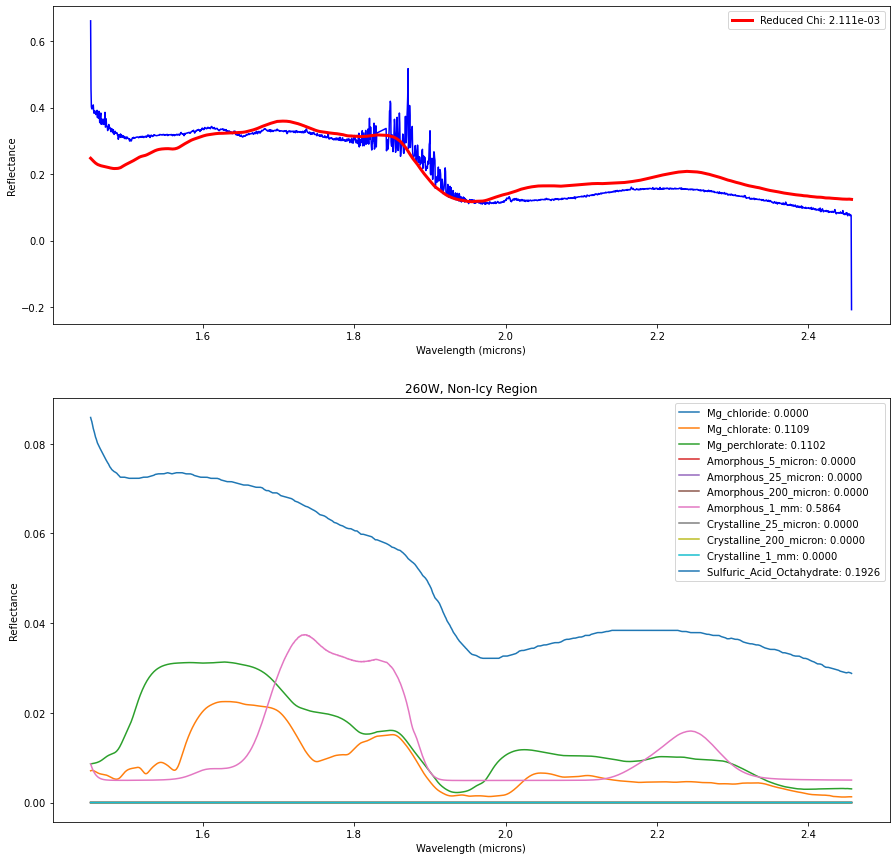

In [168]:
fig, ax = plt.subplots(2,1, figsize=(15,15), 
                       gridspec_kw={'height_ratios': [1.5, 2]})
plt.title('260W, Non-Icy Region')

ax[0].plot(waves, b, color='b')
ax[0].plot(waves, constrained_slope_adjusted.estimate(csa_out.params), color='r', linewidth=3, 
           label='Reduced Chi: '+format(csa_out.redchi,'.3e'))

ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('Reflectance')
ax[0].legend()

#Plot components
for i,p in enumerate(csa_out.params.values()):
    if p.name != 'S':
        ax[1].plot(waves, constrained_slope_adjusted.A[:,i]*p.value, 
               label=p.name+': '+format(p.value,'0.4f'))
    #else:
    #    ax[1].plot(waves, S*waves - 15, label='S: '+format(p.value,'0.4f'))

#ax[1].set_yscale('log')    
ax[1].legend()
ax[1].set_xlabel('Wavelength (microns)')
ax[1].set_ylabel('Reflectance')

# Linear Model with Sloped Base: $b = \sum x_i A_i + (x_m \lambda + x_b)$

In [164]:
class SlopedBaseModel(SpectralModel):
    """A simple linear model, based on known wavelength and spectral library with an additional slobed base. 
    
    \sum x_i spec_i + (x_m lambda + x_b)
    """
    
    def __init__(self, waves: np.ndarray, spec_library: List[spectrum]):
        # initialize model matrix
        self.A = np.zeros((len(waves), len(spec_library)))
        for i,spec in enumerate(spec_library):
            self.A[:,i] = np.interp(waves, spec.wave, spec.A)
            
        # initialize parameters
        self._params = Parameters()
        for spec in spec_library:
            self._params.add(spec.name.replace(" ", "_"), vary=True, min=0)
            
        # Add paramater for x_m and x_b
        self._params.add('slope', vary=True, min=0)
        self._params.add('yint', vary=True, min=0)
            
    def estimate(self, params: Parameters) -> np.ndarray:
        x = np.array([p.value for p in params.values() if p.name != 'slope' and p.name != 'yint']).flatten()
        m = params['slope'].value
        yint = params['yint'].value
        return self.A @ x + (m*waves+yint)
    
    @property
    def parameters(self):
        return self._params
    
    def set_parameters(self, params):
        self._params = params

In [165]:
sloped_base = SlopedBaseModel(waves, spec_library)
rand = np.random.rand(11)
sloped_base.fill_parameters(np.concatenate([rand, [1,0]])) #Provide random starting conditions
sb_out, sb_errors = sloped_base.fit(b, method='leastsq')

report_fit(sb_out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 290
    # data points      = 1989
    # variables        = 13
    chi-square         = 1.46671002
    reduced chi-square = 7.4226e-04
    Akaike info crit   = -14319.3949
    Bayesian info crit = -14246.6549
##  Warning: uncertainties could not be estimated:
    Mg_chloride:                at boundary
    Amorphous_5_micron:         at boundary
    Amorphous_25_micron:        at boundary
    Amorphous_200_micron:       at boundary
    Crystalline_25_micron:      at boundary
    Crystalline_200_micron:     at boundary
    slope:                      at boundary
    yint:                       at boundary
[[Variables]]
    Mg_chloride:                1.8125e-10 (init = 0.6171707)
    Mg_chlorate:                0.33414446 (init = 0.8009524)
    Mg_perchlorate:             0.00362255 (init = 0.9838662)
    Amorphous_5_micron:         3.5798e-09 (init = 0.3645761)
    Amorphous_25_micron:        3.4867e-09 (init =

Text(0, 0.5, 'Reflectance')

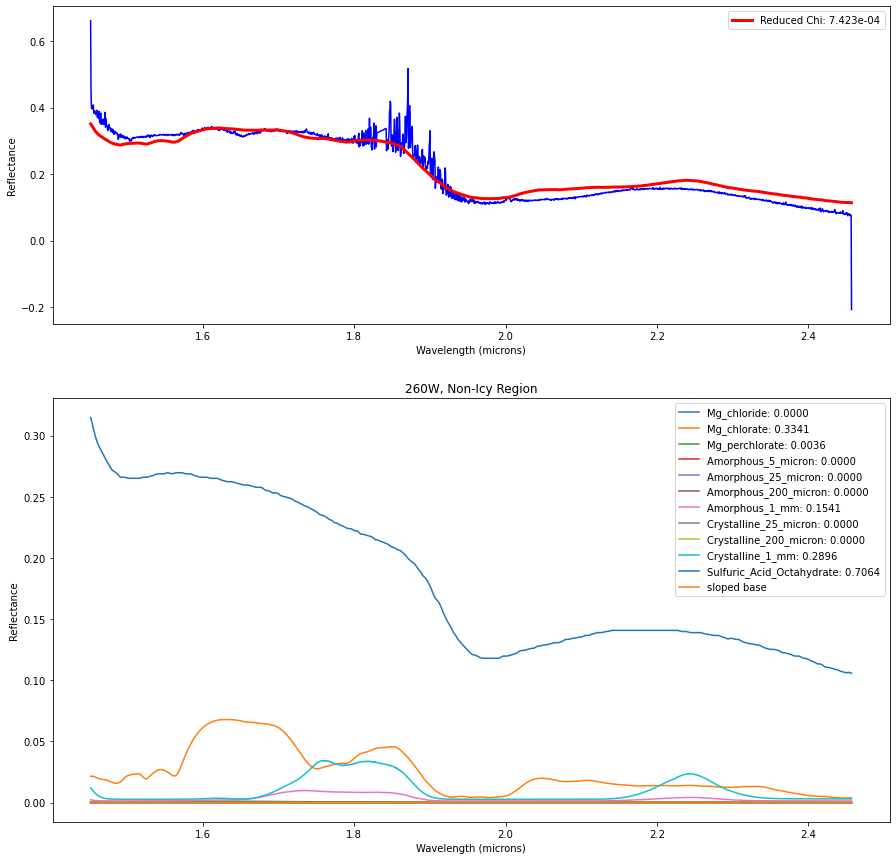

In [167]:
fig, ax = plt.subplots(2,1, figsize=(15,15), 
                       gridspec_kw={'height_ratios': [1.5, 2]})
plt.title('260W, Non-Icy Region')

ax[0].plot(waves, b, color='b')
ax[0].plot(waves, sloped_base.estimate(sb_out.params), color='r', linewidth=3, 
           label='Reduced Chi: '+format(sb_out.redchi,'.3e'))

ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('Reflectance')
ax[0].legend()

#Plot components
for i,p in enumerate(sb_out.params.values()):
    if p.name != 'slope' and p.name != 'yint':
        ax[1].plot(waves, sloped_base.A[:,i]*p.value, 
               label=p.name+': '+format(p.value,'0.4f'))
ax[1].plot(waves, sb_out.params['slope']*waves+sb_out.params['yint'] , label='sloped base')

#ax[1].set_yscale('log')    
ax[1].legend()
ax[1].set_xlabel('Wavelength (microns)')
ax[1].set_ylabel('Reflectance')

# Constrained Linear Model with Sloped Base: $b = \sum x_i A_i + x_j(x_m \lambda + x_b)$
# where $\sum x_i + x_j = 1$

In [175]:
class ConstrainedSlopedBaseModel(SpectralModel):
    """A simple linear model, based on known wavelength and spectral library with an additional slobed base 
    where the coefficients are constrained to sum to 1. 
    0
    \sum x_i spec_i + x_j(x_m lambda + x_b) where \sum(x_i) + x_j = 1
    """
    
    def __init__(self, waves: np.ndarray, spec_library: List[spectrum]):
        # initialize model matrix
        self.A = np.zeros((len(waves), len(spec_library)))
        for i,spec in enumerate(spec_library):
            self.A[:,i] = np.interp(waves, spec.wave, spec.A)
            
        # initialize parameters
        self._params = Parameters()
        
        # Add paramater for x_j, x_m, and x_b
        self._params.add('x_j', vary=True, min=0)
        self._params.add('x_m', vary=True, min=0)
        self._params.add('x_b', vary=True, min=0)
        
        #Constrain all parameters (x_i and x_j) to sum to 1 
        expr = '1-x_j'
        for spec in spec_library[:-1]:
            #Create initial blank paramters to allow expression building
            self._params.add(spec.name.replace(" ", "_"), vary=True, min=0)
            
            #Add to constraint expression
            expr+= '-'+str(spec.name.replace(" ", "_")) 
        #Constrain all parameters to sum to 1    
        self._params.add(spec_library[-1].name.replace(" ", "_"), vary=True, min=0, expr=expr)
            
        
            
    def estimate(self, params: Parameters) -> np.ndarray:
        x = np.array([p.value for p in params.values() if not 'x_' in p.name]).flatten()
        x_j = params['x_j'].value
        slope = params['x_m'].value
        yint = params['x_b'].value
        return self.A @ x + x_j*(slope*waves+yint)
    
    @property
    def parameters(self):
        return self._params
    
    def set_parameters(self, params):
        self._params = params

In [177]:
constrained_sloped_base = ConstrainedSlopedBaseModel(waves, spec_library)
rand = np.random.rand(12)
rand /= np.sum(rand)
constrained_sloped_base.fill_parameters(np.concatenate([[rand[0]], [1,0], rand[1:]])) #Provide random starting conditions
csb_out, csb_errors = constrained_sloped_base.fit(b, method='leastsq')

report_fit(csb_out)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 851
    # data points      = 1989
    # variables        = 13
    chi-square         = 1.62647893
    reduced chi-square = 8.2312e-04
    Akaike info crit   = -14113.7409
    Bayesian info crit = -14041.0008
##  Warning: uncertainties could not be estimated:
    x_j:                        at boundary
    x_b:                        at boundary
    Mg_chloride:                at boundary
    Amorphous_5_micron:         at boundary
    Amorphous_25_micron:        at boundary
    Amorphous_1_mm:             at boundary
    Crystalline_25_micron:      at boundary
    Crystalline_200_micron:     at boundary
    Crystalline_1_mm:           at boundary
[[Variables]]
    x_j:                        2.0074e-09 (init = 0.01010661)
    x_m:                        0.01075231 (init = 1)
    x_b:                        0.00000000 (init = 0)
    Mg_chloride:                1.8869e-09 (init = 0.1600338)
    Mg_chlorate:    

Text(0, 0.5, 'Reflectance')

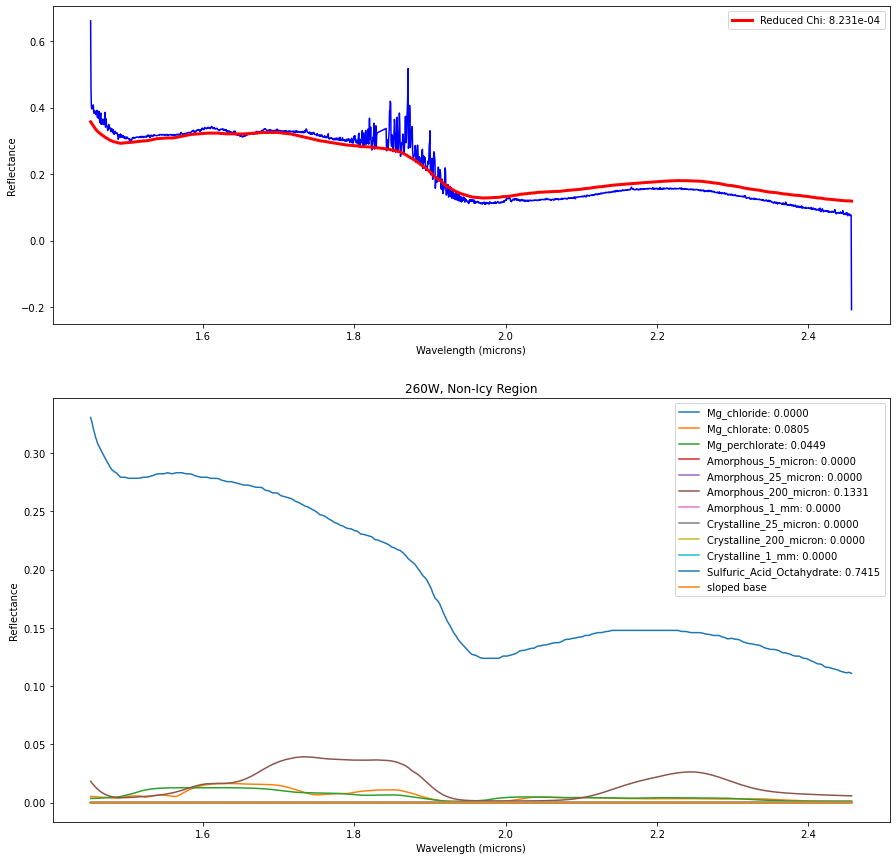

In [181]:
fig, ax = plt.subplots(2,1, figsize=(15,15), 
                       gridspec_kw={'height_ratios': [1.5, 2]})
plt.title('260W, Non-Icy Region')

ax[0].plot(waves, b, color='b')
ax[0].plot(waves, constrained_sloped_base.estimate(csb_out.params), color='r', linewidth=3, 
           label='Reduced Chi: '+format(csb_out.redchi,'.3e'))

ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('Reflectance')
ax[0].legend()

#Plot components
i=0
for p in csb_out.params.values():
    if 'x_' not in p.name:
        ax[1].plot(waves, constrained_sloped_base.A[:,i]*p.value, 
               label=p.name+': '+format(p.value,'0.4f'))
        i+=1
ax[1].plot(waves, csb_out.params['x_j']*(csb_out.params['x_m']*waves+csb_out.params['x_b']) 
           , label='sloped base')

#ax[1].set_yscale('log')    
ax[1].legend()
ax[1].set_xlabel('Wavelength (microns)')
ax[1].set_ylabel('Reflectance')

# See Mathematically best possible fit for this family of functions:

## Slope Adjusted per Spectra: $b = \sum x_i*A_i*\lambda + A_i*y_i$


In [183]:
class SlopedAdjustedPerSpecModel(SpectralModel):
    """Not physically reasonable, but to see "mathematically best possible fit", we let the slope of 
    each spectrum vary independently
    """
    
    def __init__(self, waves: np.ndarray, spec_library: List[spectrum]):
        # initialize model matrix
        self.A = np.zeros((len(waves), len(spec_library)))
        for i,spec in enumerate(spec_library):
            self.A[:,i] = np.interp(waves, spec.wave, spec.A)
            
        # initialize parameters
        self._params = Parameters()
        for spec in spec_library:
            self._params.add(spec.name.replace(" ", "_"), vary=True, min=0)
            self._params.add(spec.name.replace(" ", "_")+'_y', vary=True, min=0)
            
    def estimate(self, params: Parameters) -> np.ndarray:
        x = np.array([p.value for p in params.values() if '_y' not in p.name]).flatten()
        y = np.array([p.value for p in params.values() if '_y' in p.name]).flatten()
        return (self.A @ x)*waves + (self.A @ y)
    
    @property
    def parameters(self):
        return self._params
    
    def set_parameters(self, params):
        self._params = params

In [185]:
indiv_slope_adjusted = SlopedAdjustedPerSpecModel(waves, spec_library)
indiv_slope_adjusted.fill_parameters(np.random.rand(22)) #Provide random starting conditions
isa_out, isa_errors = indiv_slope_adjusted.fit(b, method='leastsq')

report_fit(isa_out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1209
    # data points      = 1989
    # variables        = 22
    chi-square         = 1.46671004
    reduced chi-square = 7.4566e-04
    Akaike info crit   = -14301.3949
    Bayesian info crit = -14178.2964
##  Warning: uncertainties could not be estimated:
    Mg_chloride:                  at boundary
    Mg_chloride_y:                at boundary
    Mg_chlorate:                  at boundary
    Mg_perchlorate:               at boundary
    Amorphous_5_micron:           at boundary
    Amorphous_5_micron_y:         at boundary
    Amorphous_25_micron:          at boundary
    Amorphous_25_micron_y:        at boundary
    Amorphous_200_micron:         at boundary
    Amorphous_200_micron_y:       at boundary
    Amorphous_1_mm:               at boundary
    Crystalline_25_micron:        at boundary
    Crystalline_25_micron_y:      at boundary
    Crystalline_200_micron:       at boundary
    Crystalline_200

Text(0, 0.5, 'Reflectance')

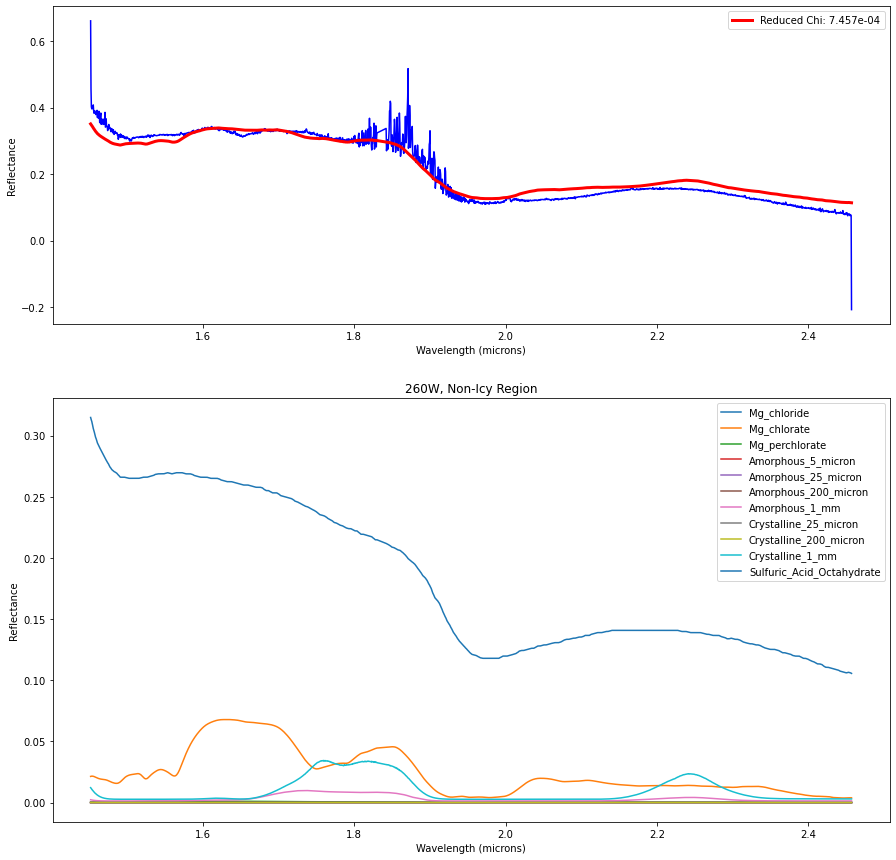

In [189]:
fig, ax = plt.subplots(2,1, figsize=(15,15), 
                       gridspec_kw={'height_ratios': [1.5, 2]})
plt.title('260W, Non-Icy Region')

ax[0].plot(waves, b, color='b')
ax[0].plot(waves, indiv_slope_adjusted.estimate(isa_out.params), color='r', linewidth=3, 
           label='Reduced Chi: '+format(isa_out.redchi,'.3e'))

ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('Reflectance')
ax[0].legend()

#Plot components
i=0
for key in isa_out.params.keys():
    if '_y' not in key:
        A = indiv_slope_adjusted.A[:,i]
        ax[1].plot(waves, isa_out.params[key].value*A*waves + A*isa_out.params[key+'_y'], 
               label=isa_out.params[key].name)#+': '+format(isa_out.params[key].value,'0.4f'))
        i+=1

#ax[1].set_yscale('log')    
ax[1].legend()
ax[1].set_xlabel('Wavelength (microns)')
ax[1].set_ylabel('Reflectance')